In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split

import tensorflow as tf
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

print("PyTorch ver.: ", torch.__version__)

PyTorch ver.:  1.0.0


In [6]:
# シード固定
def fix_seed(seed=42):  # https://www.kaggle.com/kaerunantoka/titanic-pytorch-nn-tutorial
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    
# torchモデル構築
def torch_build(net, X, y, lr, loss_fn, epochs=20, ):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_fn = loss_fn

    losses = []
    for epoc in tqdm(range(epochs)):
        optimizer.zero_grad()  # 勾配の値を初期化
        y_pred = net(X)  # 予測値を計算
        if net[-1].out_features==1:
            loss = loss_fn(y_pred.view_as(y), y)  # lossを計算、view_asでshapeを変換
        else:
            loss = loss_fn(y_pred, y)
        loss.backward()  # loss の w による微分を計算
        optimizer.step()  # 勾配を更新する
        losses.append(loss.item())  # 収束確認のために loss を記録しておく
        
    return net, losses


# Loader によるモデル構築
def torch_build_loader(net, loader, lr, loss_fn, epochs=20, ):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_fn = loss_fn

    losses = []
    for epoc in tqdm(range(epochs)):
        running_loss = 0.0
        for xx, yy in loader:
            # xx, yy は batch_size個分のみ受け取れる
            y_pred = net(xx)  # 線形モデルで y の予測値を計算
            loss = loss_fn(y_pred, yy)  # MSE loss と w による微分を計算
            optimizer.zero_grad()  # 前回の backward メソッドで計算された勾配の値を削除
            loss.backward()
            optimizer.step()  # 勾配を更新する
            running_loss += loss.item()
        losses.append(running_loss)

    return net, losses


# Loader によるモデル構築
def torch_build_loader_split(net, loader, X_test, y_test, lr, loss_fn, epochs=20, ):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_fn = loss_fn
    
    net.train()  # ネットワークを訓練モードにする
    train_losses = []
    test_losses = []
    for epoc in tqdm(range(epochs)):
        running_loss = 0.0
            
        for i, (xx, yy) in enumerate(loader):
            # xx, yy は batch_size個分のみ受け取れる
            y_pred = net(xx)  # 線形モデルで y の予測値を計算
            loss = loss_fn(y_pred, yy)  # MSE loss と w による微分を計算
            optimizer.zero_grad()  # 前回の backward メソッドで計算された勾配の値を削除
            loss.backward()
            optimizer.step()  # 勾配を更新する
            running_loss += loss.item()
        losses.append(running_loss)

        net.eval()  # ネットワークを評価モードにして、検証データの損失関数を計算する
        train_losses.append(running_loss / i)
        y_pred = net(X_test)
        test_loss = loss_fn(y_pred, y_test)
        test_losses.append(test_loss.item())

    return net, y_pred, train_losses, test_losses


# 予測
def torch_predict(net, X, y):
    h = net(X)  # 線形結合の結果
    
    try:
        output_features = net[-1].out_features
    except:
        output_features = net.out_features
    
    if output_features==1:
        prob = torch.sigmoid(h)  # シグモイド関数を作用させた結果は y=1 の確率を表す
        y_pred = prob > 0.5  # 確率が0.5以上のものをクラス1と予想し、それ以外を0とする
        accuracy_score = (y.byte() == y_pred.view_as(y)).sum().item() / len(y)  # PyTorch には Bool型がないので対応する型として ByteTensor が出力される
    else:
        prob, y_pred = torch.max(h, 1)
        accuracy_score = (y_pred==y).sum().item() / len(y)
        
    return prob, y_pred, accuracy_score


# ロスの減少の様子をグラフ化する
def plot_losses(losses):
    plt.plot(losses)
    plt.show()
    

# ロスの減少の様子をグラフ化する
def plot_losses_split(tr_losses, te_losses):
    plt.plot(tr_losses, label='train')
    plt.plot(te_losses, label='test')
    plt.legend()
    plt.show()

In [7]:
fix_seed()
plt.rcParams['figure.figsize']=(10,5)
sns.set()

## 単純な MLP構築

In [8]:
def load_data():
    digits = load_digits()
    X = digits.data
    y = digits.target

    # NumPy の ndarray を PyTorch の Tensor に変換
    X = torch.tensor(X, dtype = torch.float32)
    y = torch.tensor(y, dtype = torch.int64)
    return X, y

100%|██████████| 100/100 [00:00<00:00, 199.97it/s]


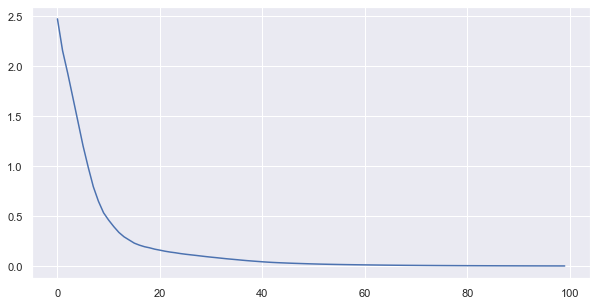

In [10]:
X, y = load_data()

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

net, losses = torch_build(net, X, y, lr=0.01, loss_fn=nn.CrossEntropyLoss(), epochs=100, )
plot_losses(losses)

In [11]:
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


In [12]:
prob, y_pred, accuracy_score = torch_predict(net, X, y)
print("正解率: ", accuracy_score)

正解率:  1.0


## Data Loader

100%|██████████| 30/30 [00:01<00:00, 18.82it/s]


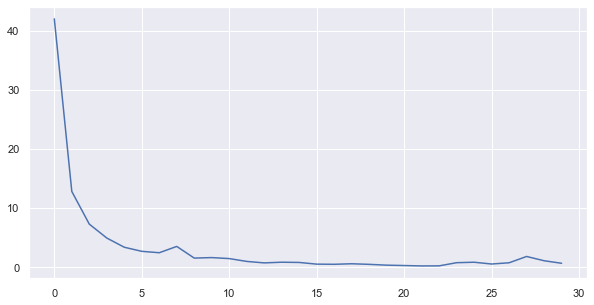

In [13]:
# TensorDataset を DataLoader に渡してデータの一部のみを簡単に受け取る例
ds = TensorDataset(X, y)  # Dataset を作成
loader = DataLoader(ds, batch_size=64, shuffle=True)  # 異なる順番で64個ずつデータを返す DataLoader を作成

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

net, losses = torch_build_loader(net, loader, lr=0.01, loss_fn=nn.CrossEntropyLoss(), epochs=30, )
plot_losses(losses)

In [15]:
prob, y_pred, accuracy_score = torch_predict(net, X, y)
print("正解率: ", accuracy_score)

正解率:  0.9961046188091264


## Dropout による正則化

In [16]:
# 全体の30%用は検証用
def load_data_split():
    digits = load_digits()
    X = digits.data
    y = digits.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.int64)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.int64)
    return X_train, X_test, y_train, y_test

100%|██████████| 100/100 [00:22<00:00,  3.79it/s]


過学習を起こし、test の損失関数が上昇してしまっている


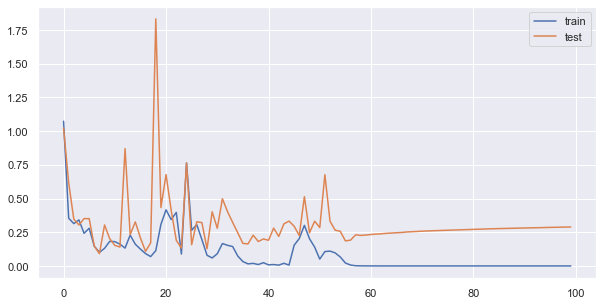

In [18]:
X_train, X_test, y_train, y_test = load_data_split()

# TensorDataset を DataLoader に渡してデータの一部のみを簡単に受け取る例
ds = TensorDataset(X_train, y_train)  # Dataset を作成
loader = DataLoader(ds, batch_size=32, shuffle=True)  # 異なる順番で64個ずつデータを返す DataLoader を作成

# 層を積み重ねて深い NN を構築する
k = 100
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, 10)
)

net, y_pred, train_losses, test_losses = torch_build_loader_split(net, loader, X_test, y_test, lr=0.01, loss_fn=nn.CrossEntropyLoss(), epochs=100, )
print("過学習を起こし、test の損失関数が上昇してしまっている")
plot_losses_split(train_losses, test_losses)

100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


Dropout を追加することで過学習が抑えられている


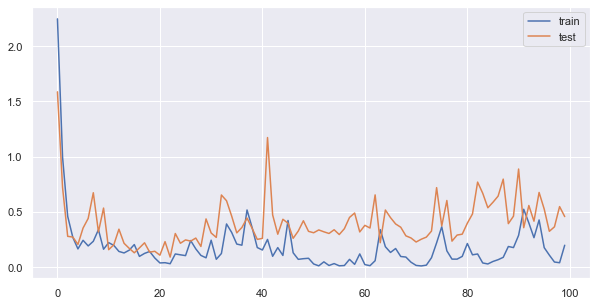

In [19]:
# train と eval メソッドで Dropout の挙動を切り替える１

# 確率0.5でランダムに変数の次元を捨てる Dropout を各層に追加
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, 10)
)

net_dropout, y_pred_dropout, train_losses_dropout, test_losses_dropout = torch_build_loader_split(net, loader, X_test, y_test, lr=0.01, loss_fn=nn.CrossEntropyLoss(), epochs=100, )
print("Dropout を追加することで過学習が抑えられている")
plot_losses_split(train_losses_dropout, test_losses_dropout)

## BatchNorm

100%|██████████| 100/100 [00:28<00:00,  3.29it/s]


BatchNorm


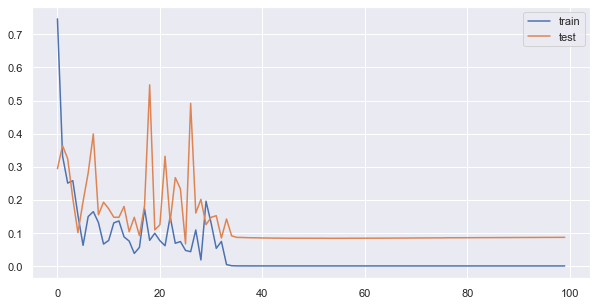

In [20]:
# train と eval メソッドで Batch Normalization の挙動を切り替える

# train と eval メソッドで Dropout の挙動を切り替える２
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, 10)
)

net_batchnorm, y_pred_batchnorm, train_losses_batchnorm, test_losses_batchnorm = torch_build_loader_split(net, loader, X_test, y_test, lr=0.01, loss_fn=nn.CrossEntropyLoss(), epochs=100, )
print("BatchNorm")
plot_losses_split(train_losses_batchnorm, test_losses_batchnorm)

## 独自のネットワーク層（カスタム層）を作る

In [21]:
## 活性化関数ReLU と Dropout　を含んだカスタムの線形層を作り、それを用いて MLP を記述
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x
        
mlp = nn.Sequential(
    CustomLinear(64, 200),
    CustomLinear(200, 200),
    CustomLinear(200, 200),
    nn.Linear(200, 10)
)

In [22]:
# ## nn.Module を継承したクラスの利用
# class MyMLP(nn.Module):
#     def __init__(self, in_features, out_features):
#         super().__init__()
#         self.ln1 = CustomLinear(in_features, 200),
#         self.ln2 = CustomLinear(200, 200),
#         self.ln3 = CustomLinear(200, 200),
#         self.ln4 = CustomLinear(200, out_features),
        
#     def forward(self, x):
#         x = self.ln1(x)
#         x = self.ln2(x)
#         x = self.ln3(x)
#         x = self.ln4(x)
#         return x
    
# mlp = MyMLP(64, 10)

100%|██████████| 100/100 [00:24<00:00,  3.86it/s]


dropout
0.08801941573619843 71


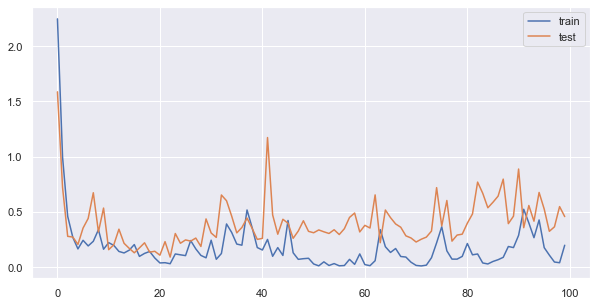

custom layer
0.15405313670635223 19


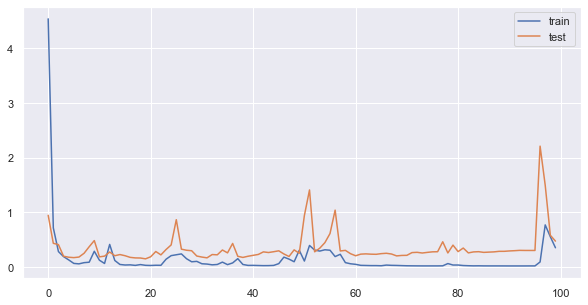

In [27]:
net, y_pred, train_losses, test_losses = torch_build_loader_split(mlp, loader, X_test, y_test, lr=0.01, loss_fn=nn.CrossEntropyLoss(), epochs=100)

print("dropout")
print(np.min(test_losses_dropout), np.argmin(train_losses_dropout))
plot_losses_split(train_losses_dropout, test_losses_dropout)

print("custom layer")
print(np.min(test_losses), np.argmin(test_losses))
plot_losses_split(train_losses, test_losses)